In [ ]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [ ]:
# Считывание файла в формате .xes
#log = xes_importer.apply('<path_to_xes_file.xes>')

In [ ]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('https://raw.githubusercontent.com/Adelaaas/Process_mining_lab_hes/main/ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [ ]:
type(log_csv)

pandas.core.frame.DataFrame

In [ ]:
log_csv.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [ ]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [ ]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']}) 

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [ ]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [ ]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


<Axes: xlabel='relativetime_s', ylabel='patient'>

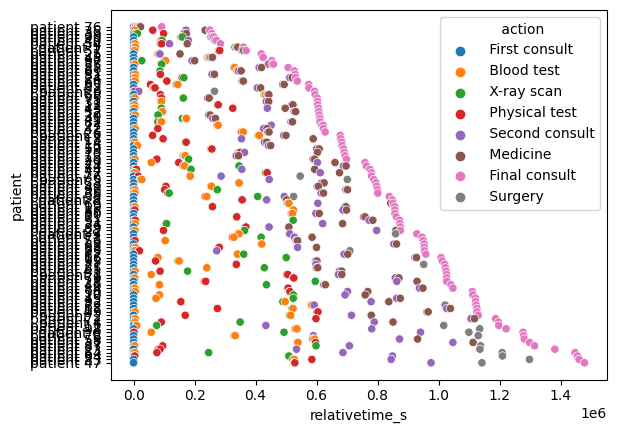

In [ ]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])

# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])

In [ ]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [ ]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [ ]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [ ]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [ ]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [ ]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [ ]:
# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

In [ ]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

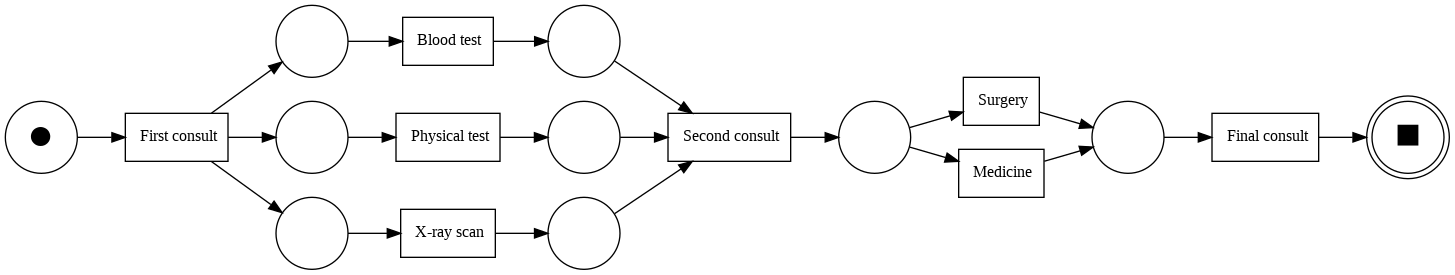

In [ ]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

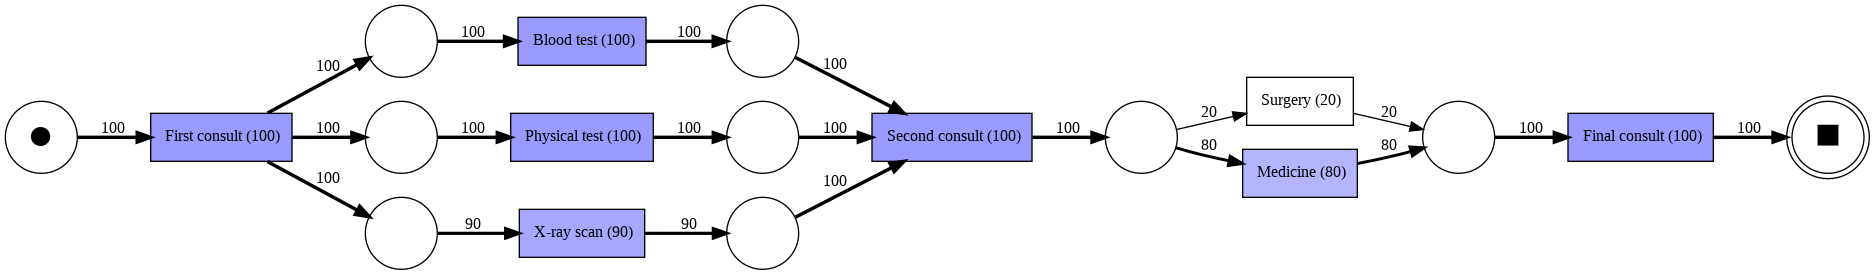

In [ ]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [ ]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

In [ ]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( X-ray scan, ' X-ray scan')", "( Physical test, ' Physical test')", "( Blood test, ' Blood test')", "( Second consult, ' Second consult')", "( Surgery, ' Surgery')", "( Medicine, ' Medicine')", "( Final consult, ' Final consult')"])

In [ ]:
log_csv[log_csv['case:concept:name'] == 'patient 13']


,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34


**Среднее время операции**: 4 дней
**Максимальное время операции**: 7 days
**Минимальное время операции**: 0 days, i.e. 8.469 hours


<ipython-input-53-519b8342d55c>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(surgery_time)


<Axes: ylabel='Density'>

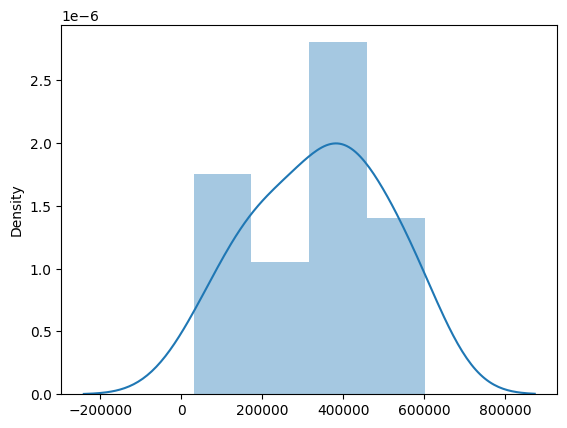

In [ ]:
import numpy as np
import seaborn as sns

surgery_time = traces["( Surgery, ' Surgery')"]['all_values']
seconds_to_days = 60*60*24
seconds_to_hours = 60*60
print('**Среднее время операции**: {:.0f} дней'.format(np.mean(surgery_time)/seconds_to_days))
print('**Максимальное время операции**: {:.0f} days'.format(np.max(surgery_time)/seconds_to_days))
print('**Минимальное время операции**: {:.0f} days, i.e. {:.3f} hours'.format(np.min(surgery_time)/seconds_to_days, np.min(surgery_time)/seconds_to_hours))
sns.distplot(surgery_time)

1. Минимальное количество событий

In [ ]:
print("Минимальное количество событий ", min(log_csv.groupby('case:concept:name').count()['concept:name']))

Минимальное количество событий  6


2. Какие события являются общими для всех процессов?

In [ ]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activ = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activ

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

3. Найдите наибоее часто встречающуюся последовательность событий.

In [ ]:
top = case_statistics.get_variant_statistics(log_csv)[0]
top

{'variant': (' First consult',
  ' Blood test',
  ' X-ray scan',
  ' Physical test',
  ' Second consult',
  ' Medicine',
  ' Final consult'),
 'count': 18}

Какой пациент на лечение тратил меньше всего времени, а какой больше?

In [ ]:
print("Наибольшее:") 
print(log_csv.groupby('case:concept:name')['relativetime_s'].sum().reset_index().query(f"relativetime_s == {max(log_csv.groupby('case:concept:name')['relativetime_s'].sum())}")) 
print("Наименьшее:") 
print(log_csv.groupby('case:concept:name')['relativetime_s'].sum().reset_index().query(f"relativetime_s == {min(log_csv.groupby('case:concept:name')['relativetime_s'].sum())}"))

Наибольшее:
   case:concept:name  relativetime_s
82        patient 83         5237888
Наименьшее:
   case:concept:name  relativetime_s
74        patient 76          163885


Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)

In [ ]:
log_csv['NumActions in Case'] = log_csv.groupby('case:concept:name').cumcount()+1
log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,1
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,2
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17,3
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17,4
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17,5
...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32,3
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32,4
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32,5
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32,6


Pation 13 с каким врачом/врачами он/она консультировался?

In [ ]:
from pm4py.algo.filtering.pandas.attributes import attributes_filter
Patient26 = attributes_filter.apply(log_csv, ["patient 13"],
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "case:concept:name", 
                                                      attributes_filter.Parameters.POSITIVE: True})
Patient13

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34,1
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34,2
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34,3
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34,4
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34,5
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34,6
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34,7


Какое событие является наиболее ресурсоёмким в данном журнале событий?

In [ ]:
log_csv.query(f"relativetime_s == {max(log_csv['relativetime_s'])}")

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
327,patient 47,Final consult,Dr. Anna,2017-03-27 12:10:48,2017-03-27 12:10:48,2017-03-10 09:27:44,17 days 02:43:04,1478584,17,17 days 02:43:04,7


Есть ли врачи или медсестры, которые перегружены работой?

In [ ]:
log_csv.groupby('org:resource').sum(numeric_only=True)['relativetime_s']

org:resource
 Dr. Alex        4954952
 Dr. Anna       74359781
 Dr. Ben        39373517
 Dr. Bob        24111209
 Dr. Charlie     4674444
 Dr. Quinn       1430397
 Dr. Rudy        6917280
 Lab            16639813
 Nurse Corey     9555756
 Nurse Jesse    11358992
 Pharmacy       46524458
 Team 1         13219210
 Team 2         14827272
Name: relativetime_s, dtype: int64

Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?

In [ ]:
resource1 = log_csv.groupby('org:resource')['concept:name'].nunique()
events = resource1.sum()
ans = resource1 / events
ans

org:resource
 Dr. Alex       0.0625
 Dr. Anna       0.1875
 Dr. Ben        0.0625
 Dr. Bob        0.1250
 Dr. Charlie    0.0625
 Dr. Quinn      0.0625
 Dr. Rudy       0.0625
 Lab            0.0625
 Nurse Corey    0.0625
 Nurse Jesse    0.0625
 Pharmacy       0.0625
 Team 1         0.0625
 Team 2         0.0625
Name: concept:name, dtype: float64

Какие события связаны с узкими местами и какие ресурсы задействованы?

In [ ]:
import pandas as pd
import numpy as np

seconds_to_hours = 60*60
log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby(['case:concept:name'])['diff'].shift(-1)
log_csv['time'] = log_csv['time'] / seconds_to_hours
log_csv.drop('diff', axis=1, inplace=True)
pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               # values=["relativetime_s"],
               values=["time"],
               aggfunc=np.sum)

time
concept:name    org:resource                          
 Blood test      Lab         0 days 01:20:33.284166625
 Final consult   Dr. Anna              0 days 00:00:00
                 Dr. Ben               0 days 00:00:00
 First consult   Dr. Anna    0 days 00:27:43.779166643
                 Dr. Bob     0 days 00:34:08.394166647
 Medicine        Pharmacy    0 days 01:08:27.125277737
 Physical test   Nurse Corey 0 days 00:30:37.866944428
                 Nurse Jesse 0 days 00:37:15.065277754
 Second consult  Dr. Anna    0 days 00:23:05.849166644
                 Dr. Bob     0 days 00:20:26.003055534
 Surgery         Dr. Alex    0 days 00:05:22.890277776
                 Dr. Charlie 0 days 00:03:52.926666664
                 Dr. Quinn   0 days 00:01:07.731111110
                 Dr. Rudy    0 days 00:05:37.135833330
 X-ray scan      Team 1      0 days 00:21:02.561944427
                 Team 2      0 days 00:23:44.288055534

Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?

<Axes: xlabel='relativetime_s', ylabel='case:concept:name'>

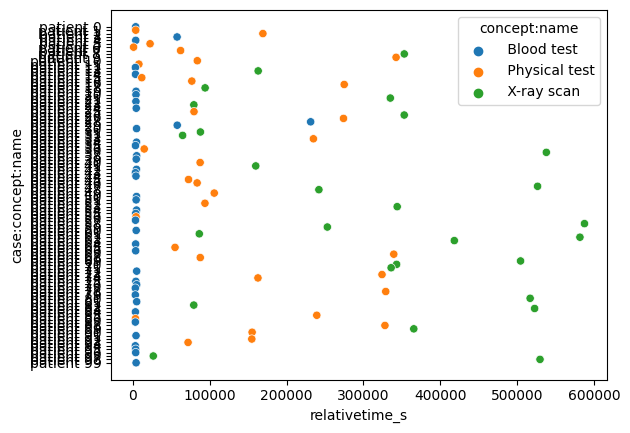

In [ ]:
sns.scatterplot(x=tracefilter_log_pos['relativetime_s'], y=tracefilter_log_pos['case:concept:name'], hue=tracefilter_log_pos['concept:name'])

Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.

In [ ]:
!pip install pyvis
import pyvis
hw_values = pm4py.discover_handover_of_work_network(event_log) 
pm4py.view_sna(hw_values)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


Задание

Inductive

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

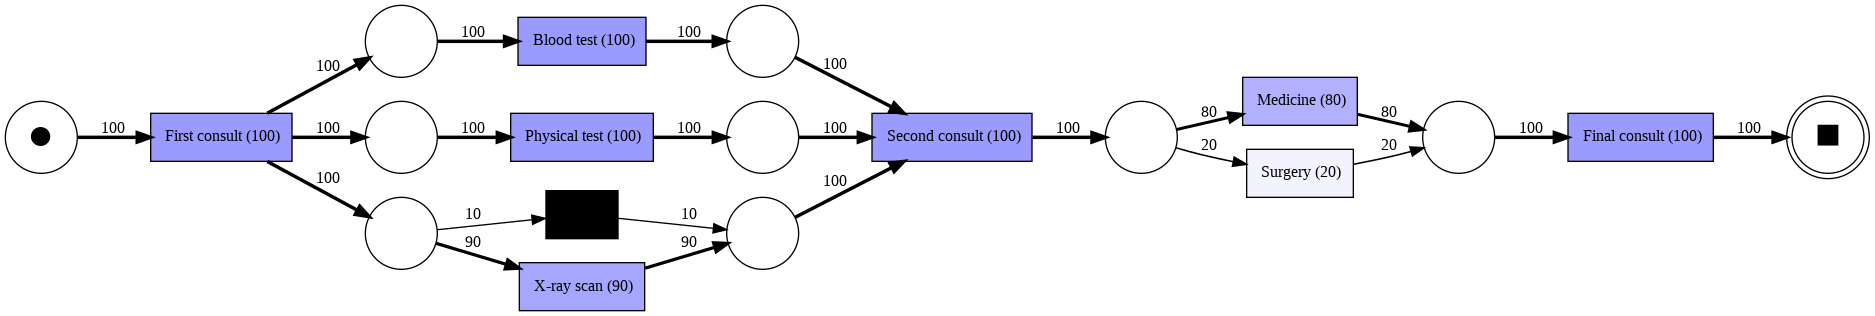

In [ ]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
import pm4py
net, im, fm = pm4py.discover_petri_net_inductive(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

Простота равна  0.6363636363636362


In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999915967092714}


In [ ]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance {prec}\n")
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance 0.7089171974522293



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance 0.7089171974522293



In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение 0.7089171974522293



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

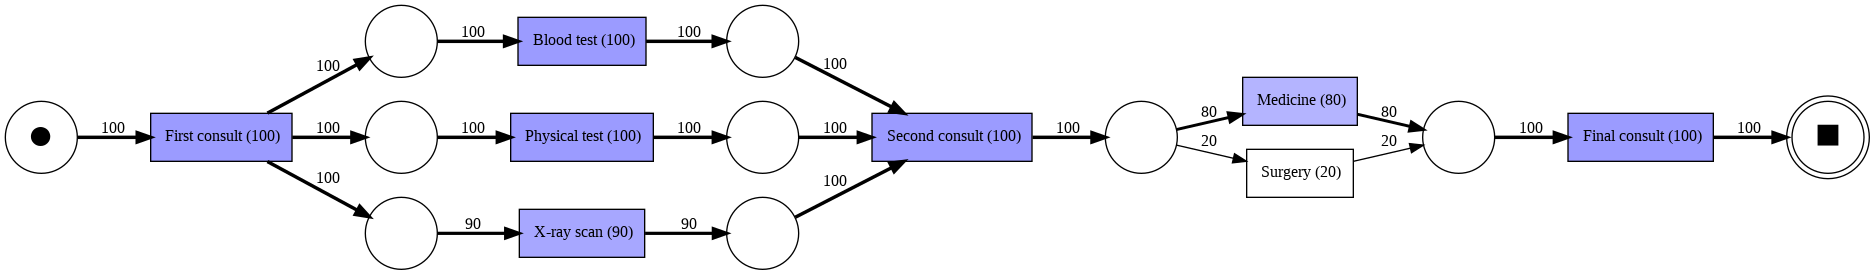

In [ ]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

net, im, fm = heuristics_miner.apply(event_log)

from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота  ", simp)

Простота   0.8181818181818181


In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение 0.7089171974522293



In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение 0.7089171974522293



Alpha

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

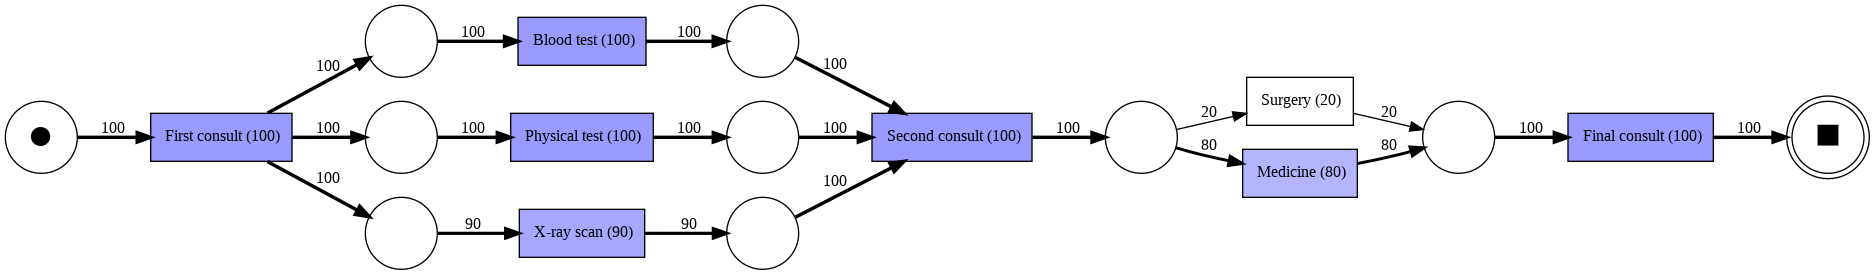

In [ ]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

net, im, fm = alpha_miner.apply(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

Простота равна  0.8181818181818181


In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение 0.7089171974522293



In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение 0.7089171974522293



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

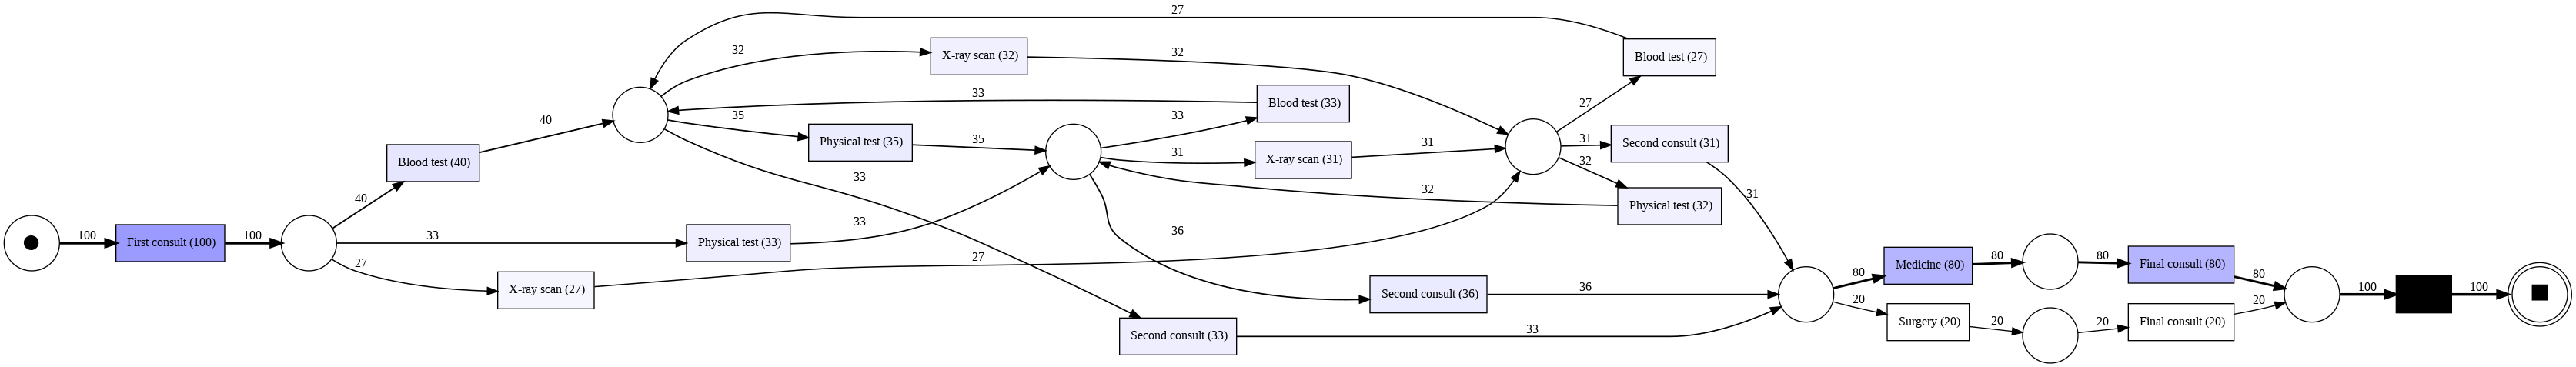

In [ ]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(event_log)
from pm4py.objects.conversion.dfg import converter as dfg_mining
net, im, fm = dfg_mining.apply(dfg)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

Простота равна  0.6363636363636362


In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999915967092714}


In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение 0.7089171974522293



In [ ]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение {prec}\n")

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение 0.7089171974522293

